pysindy is already installed.
Processing video resolution: 1920x1080


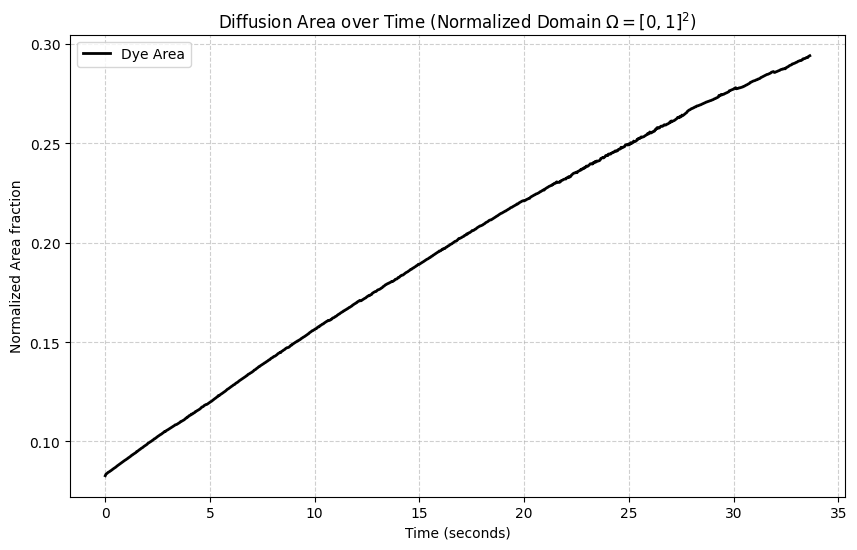

Final Area Coverage: 0.2940 (or 29.40%)


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import subprocess

try:
    import pysindy as ps
    print("pysindy is already installed.")
except ImportError:
    print("pysindy not found. Installing now...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pysindy"])
    import pysindy as ps
    print("pysindy installed and imported successfully.")
from google.colab.patches import cv2_imshow
from scipy.integrate import solve_ivp
import seaborn as sns

def analyze_dye_diffusion(video_path):

    cap = cv2.VideoCapture("/content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4")

    if not cap.isOpened():
        print("Error: Could not open video.")
        return


    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_pixels = width * height

    print(f"Processing video resolution: {width}x{height}")


    time_seconds = []
    normalized_areas = []

    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break


        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


        threshold_value = 100
        _, mask = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV)

        dye_pixel_count = cv2.countNonZero(mask)


        area_fraction = dye_pixel_count / total_pixels


        current_time = frame_idx / fps
        time_seconds.append(current_time)
        normalized_areas.append(area_fraction)

        frame_idx += 1


        # cv2_imshow(mask)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    cap.release()
    cv2.destroyAllWindows()

    return time_seconds, normalized_areas


video_file = "Video_Difusion_editado_.mp4"
times, areas = analyze_dye_diffusion(video_file)


plt.figure(figsize=(10, 6))
plt.plot(times, areas, linewidth=2, color='black', label='Dye Area')
plt.title(r'Diffusion Area over Time (Normalized Domain $\Omega = [0,1]^2$)')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Area fraction')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


print(f"Final Area Coverage: {areas[-1]:.4f} (or {areas[-1]*100:.2f}%)")

In [2]:
def create_dye_dataset(video_path, output_csv="dye_data.csv"):

    cap = cv2.VideoCapture("/content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4")

    if not cap.isOpened():
        print(f"Error: Could not open file {video_path}")
        return


    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_pixels = width * height

    print(f"Processing {video_path}...")
    print(f"Resolution: {width}x{height}, FPS: {fps}")

    data_points = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break


        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


        _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)


        dye_pixels = cv2.countNonZero(mask)
        normalized_area = dye_pixels / total_pixels
        time_sec = frame_idx / fps

        data_points.append({
            "Time_Seconds": time_sec,
            "Normalized_Area": normalized_area,
            "Pixel_Count": dye_pixels
        })

        frame_idx += 1

    cap.release()

    #Create DataFrame
    df = pd.DataFrame(data_points)

    # Save Full High-Res Dataset
    df.to_csv(output_csv, index=False)
    print(f"Full dataset saved to: {output_csv}")

    # Create 'Per Second' Dataset
    # We group by the integer part of the time and take the first entry for that second
    df['Second_Integer'] = df['Time_Seconds'].astype(int)
    df_seconds = df.groupby('Second_Integer').first().reset_index()

    # Select relevant columns
    df_seconds = df_seconds[['Time_Seconds', 'Normalized_Area']]
    df_seconds.to_csv("dye_data_per_second.csv", index=False)
    print("Per-second summary saved to: dye_data_per_second.csv")

    return df


video_filename = "Video_Difusion_editado_.mp4"
df = create_dye_dataset(video_filename)


print("\nFirst 5 seconds of data:")
print(df[df['Time_Seconds'] % 1 == 0].head())

Processing Video_Difusion_editado_.mp4...
Resolution: 1920x1080, FPS: 29.97000029702676
Full dataset saved to: dye_data.csv
Per-second summary saved to: dye_data_per_second.csv

First 5 seconds of data:
   Time_Seconds  Normalized_Area  Pixel_Count  Second_Integer
0           0.0         0.082742       171574               0


# **Derivation of ODE based on the full dataset**

In [3]:
df = pd.read_csv('dye_data.csv')
t = df['Time_Seconds'].values
A = df['Normalized_Area'].values.reshape(-1, 1)

feature_library = ps.PolynomialLibrary(degree=3)

optimizer = ps.STLSQ(threshold=0.001)

model = ps.SINDy(
    optimizer=optimizer,
    feature_library=feature_library,
    differentiation_method=ps.FiniteDifference()
)

model.fit(A, t=t, feature_names=["Area"])

print("--- Discovered Area Growth ODE ---")
model.print()

--- Discovered Area Growth ODE ---
(Area)' = 0.012 1 + -0.073 Area + 0.341 Area^2 + -0.622 Area^3


# **Real data. vs simulation**

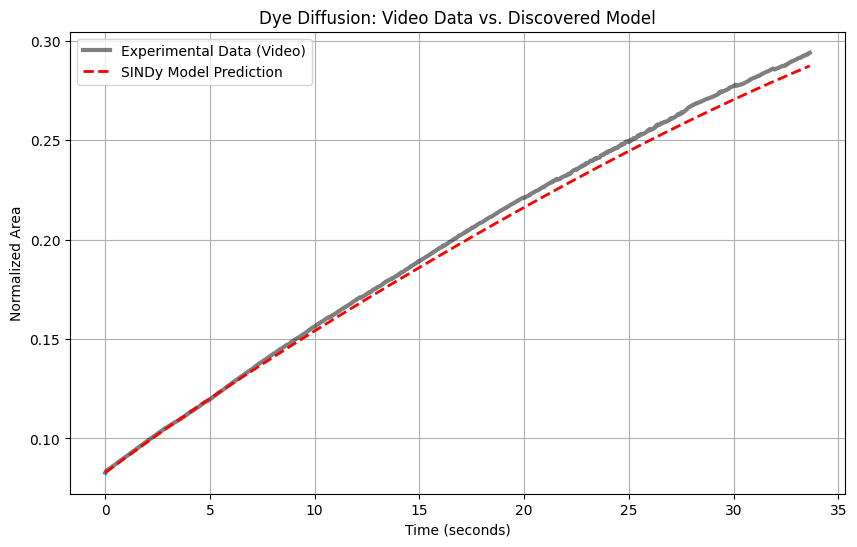

Model Mean Squared Error: 0.000017


In [4]:
from scipy.integrate import solve_ivp

def diffusion_model(t, A):

    dA_dt = 0.012 - 0.073*A + 0.341*A**2 - 0.622*A**3
    return dA_dt


A0 = [areas[0]]
t_span = (times[0], times[-1])
sol = solve_ivp(diffusion_model, t_span, A0, t_eval=times, method='RK45')
plt.figure(figsize=(10, 6))

plt.plot(times, areas, 'k-', alpha=0.5, linewidth=3, label='Experimental Data (Video)')

plt.plot(sol.t, sol.y[0], 'r--', linewidth=2, label='SINDy Model Prediction')

plt.title('Dye Diffusion: Video Data vs. Discovered Model')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Area')
plt.legend()
plt.grid(True)
plt.show()

mse = np.mean((areas - sol.y[0])**2)
print(f"Model Mean Squared Error: {mse:.6f}")

# **Derivation of 2D ODE based on the spread in x and y axis using all the data**

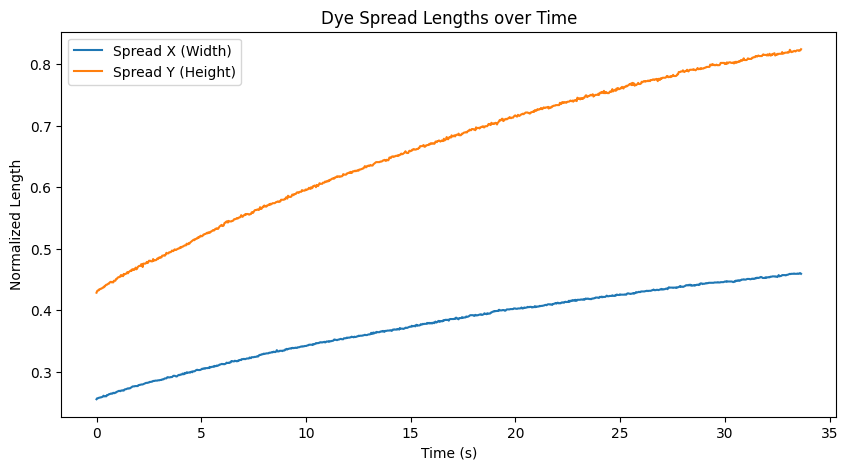

In [5]:
def extract_spread_lengths(video_path):
    cap = cv2.VideoCapture("/content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4")
    if not cap.isOpened():
        print(f"Error opening {video_path}")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    canvas_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    canvas_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    data = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            c = max(contours, key=cv2.contourArea)

            x, y, w, h = cv2.boundingRect(c)
            Lx = w / canvas_width
            Ly = h / canvas_height

        else:
            Lx, Ly = 0, 0

        time_sec = frame_idx / fps
        data.append([time_sec, Lx, Ly])
        frame_idx += 1

    cap.release()


    df = pd.DataFrame(data, columns=['Time', 'Lx', 'Ly'])
    return df

video_file = "Video_Difusion_editado_.mp4"
df_spread = extract_spread_lengths(video_file)

plt.figure(figsize=(10,5))
plt.plot(df_spread['Time'], df_spread['Lx'], label='Spread X (Width)')
plt.plot(df_spread['Time'], df_spread['Ly'], label='Spread Y (Height)')
plt.title("Dye Spread Lengths over Time")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Length")
plt.legend()
plt.show()

df_spread.to_csv("dye_spread_lengths.csv", index=False)

In [6]:
t = df_spread['Time'].values
X = df_spread[['Lx', 'Ly']].values

#
library_functions = [lambda x: x, lambda x: 1/x]
library_function_names = [lambda x: x, lambda x: "1/" + x]

custom_lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names
)

poly_lib = ps.PolynomialLibrary(degree=2)
combined_lib = poly_lib + custom_lib

optimizer = ps.STLSQ(threshold=0.001)


model = ps.SINDy(
    feature_library=combined_lib,
    optimizer=optimizer,
    differentiation_method=ps.SmoothedFiniteDifference()
)


model.fit(X, t=t, feature_names=["Lx", "Ly"])

print("--- Discovered Spread Dynamics ---")
model.print()

--- Discovered Spread Dynamics ---
(Lx)' = -0.325 1 + 0.374 Lx + -0.007 Ly + -0.170 Ly^2 + 0.374 Lx + -0.007 Ly + 0.113 1/Lx + -0.111 1/Ly
(Ly)' = -2.353 1 + 6.749 Lx + -2.198 Ly + 70.706 Lx^2 + -89.112 Lx Ly + 26.308 Ly^2 + 6.749 Lx + -2.198 Ly + 1.025 1/Lx + -1.239 1/Ly


# **Simulation vs Real data**

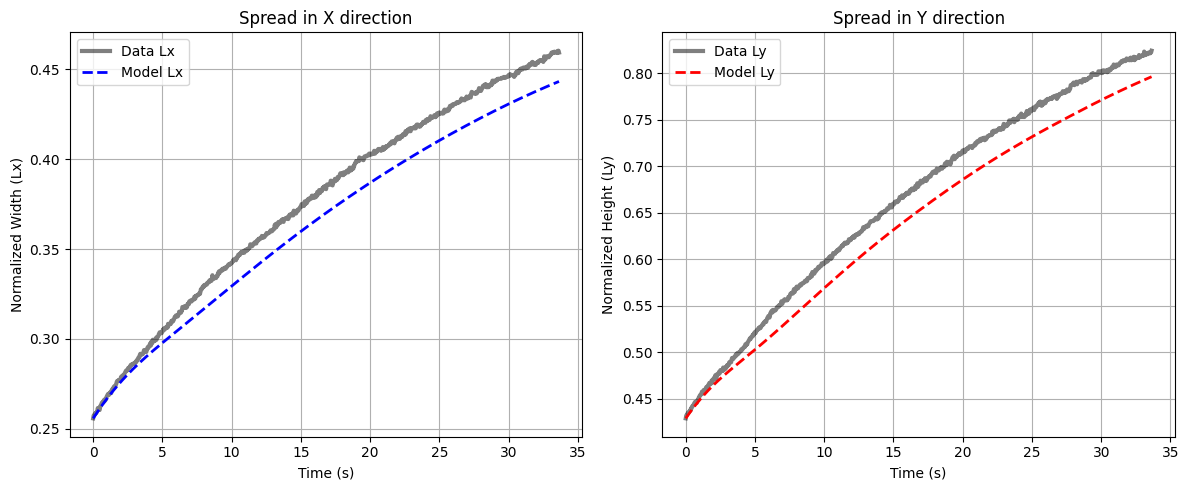

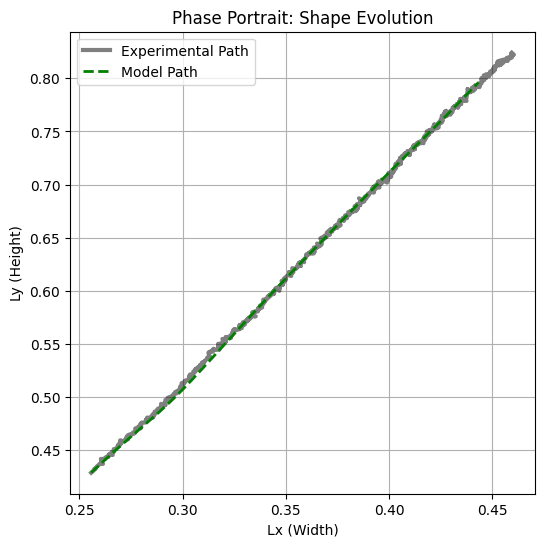

In [8]:
def spread_dynamics(t, Y):
    Lx, Ly = Y

    eps = 1e-6
    if abs(Lx) < eps: Lx = eps
    if abs(Ly) < eps: Ly = eps

    dLx_dt = (-0.325
              + 0.748 * Lx
              - 0.014 * Ly
              - 0.170 * Ly**2
              + 0.113 * (1/Lx)
              - 0.111 * (1/Ly))

    dLy_dt = (-2.353
              + 13.498 * Lx
              - 4.396 * Ly
              + 70.706 * Lx**2
              - 89.112 * Lx*Ly
              + 26.308 * Ly**2
              + 1.025 * (1/Lx)
              - 1.239 * (1/Ly))

    return [dLx_dt, dLy_dt]

start_idx = 0
while df_spread['Lx'].iloc[start_idx] == 0:
    start_idx += 1

Lx0 = df_spread['Lx'].iloc[start_idx]
Ly0 = df_spread['Ly'].iloc[start_idx]
initial_state = [Lx0, Ly0]


t_start = df_spread['Time'].iloc[start_idx]
t_end = df_spread['Time'].iloc[-1]
t_eval = df_spread['Time'].iloc[start_idx:].values


sol = solve_ivp(spread_dynamics, (t_start, t_end), initial_state, t_eval=t_eval, method='RK45')

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(t_eval, df_spread['Lx'].iloc[start_idx:], 'k-', alpha=0.5, lw=3, label='Data Lx')
plt.plot(sol.t, sol.y[0], 'b--', lw=2, label='Model Lx')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Width (Lx)')
plt.title('Spread in X direction')
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(t_eval, df_spread['Ly'].iloc[start_idx:], 'k-', alpha=0.5, lw=3, label='Data Ly')
plt.plot(sol.t, sol.y[1], 'r--', lw=2, label='Model Ly')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Height (Ly)')
plt.title('Spread in Y direction')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(df_spread['Lx'], df_spread['Ly'], 'k-', alpha=0.5, lw=3, label='Experimental Path')
plt.plot(sol.y[0], sol.y[1], 'g--', lw=2, label='Model Path')
plt.xlabel('Lx (Width)')
plt.ylabel('Ly (Height)')
plt.title('Phase Portrait: Shape Evolution')
plt.legend()
plt.grid(True)
plt.show()

# **Mean error finding**

ERROR ANALYSIS
MSE for Lx (Width) : 1.7725e-04
MSE for Ly (Height): 6.8523e-04
Total Combined MSE : 4.3124e-04


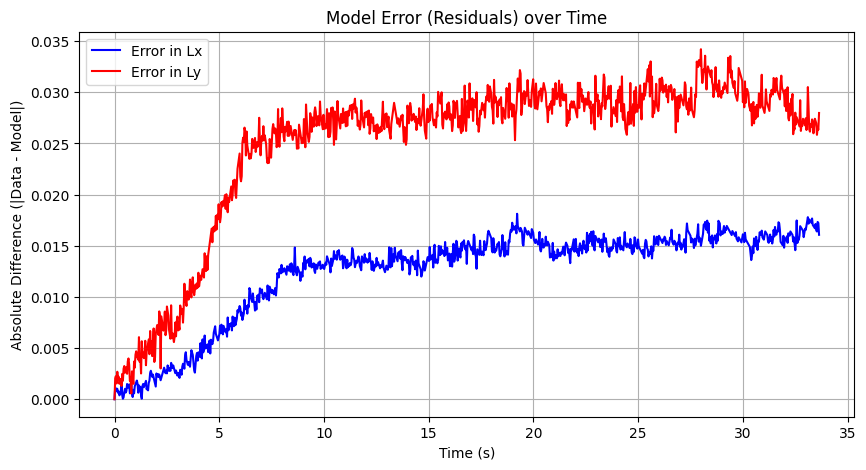

In [9]:

Lx_data = df_spread['Lx'].iloc[start_idx:].values
Ly_data = df_spread['Ly'].iloc[start_idx:].values

Lx_model = sol.y[0]
Ly_model = sol.y[1]

mse_x = np.mean((Lx_data - Lx_model)**2)
mse_y = np.mean((Ly_data - Ly_model)**2)
total_mse = (mse_x + mse_y) / 2

print("="*40)
print("ERROR ANALYSIS")
print("="*40)
print(f"MSE for Lx (Width) : {mse_x:.4e}")
print(f"MSE for Ly (Height): {mse_y:.4e}")
print(f"Total Combined MSE : {total_mse:.4e}")


residual_x = np.abs(Lx_data - Lx_model)
residual_y = np.abs(Ly_data - Ly_model)

plt.figure(figsize=(10, 5))
plt.plot(sol.t, residual_x, label='Error in Lx', color='blue')
plt.plot(sol.t, residual_y, label='Error in Ly', color='red')
plt.title("Model Error (Residuals) over Time")
plt.xlabel("Time (s)")
plt.ylabel("Absolute Difference (|Data - Model|)")
plt.legend()
plt.grid(True)
plt.show()

# **The best one**

Starting sweep over 18 combinations for Coupled System...
Deg: 1, Thresh: 0.0001 -> MSE: 9.54e-06
Deg: 1, Thresh: 0.001 -> MSE: 2.77e-06
Deg: 1, Thresh: 0.005 -> MSE: 6.12e-06


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


Deg: 1, Thresh: 0.01 -> MSE: 6.55e-01


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Deg: 1, Thresh: 0.05 -> MSE: 4.28e-02


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Deg: 1, Thresh: 0.1 -> MSE: 4.28e-02
Deg: 2, Thresh: 0.0001 -> MSE: 8.62e-06
Deg: 2, Thresh: 0.001 -> MSE: 9.05e-03
Deg: 2, Thresh: 0.005 -> MSE: 6.12e-06


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


Deg: 2, Thresh: 0.01 -> MSE: 6.55e-01


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Deg: 2, Thresh: 0.05 -> MSE: 4.28e-02


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Deg: 2, Thresh: 0.1 -> MSE: 4.28e-02
Deg: 3, Thresh: 0.0001 -> MSE: 3.17e-04
Deg: 3, Thresh: 0.001 -> MSE: 3.68e-05
Deg: 3, Thresh: 0.005 -> MSE: 6.12e-06


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:234: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(


Deg: 3, Thresh: 0.01 -> MSE: 6.55e-01


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  warnings.warn(


Deg: 3, Thresh: 0.05 -> MSE: 4.28e-02


/usr/local/lib/python3.12/dist-packages/pysindy/optimizers/stlsq.py:224: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


Deg: 3, Thresh: 0.1 -> MSE: 4.28e-02


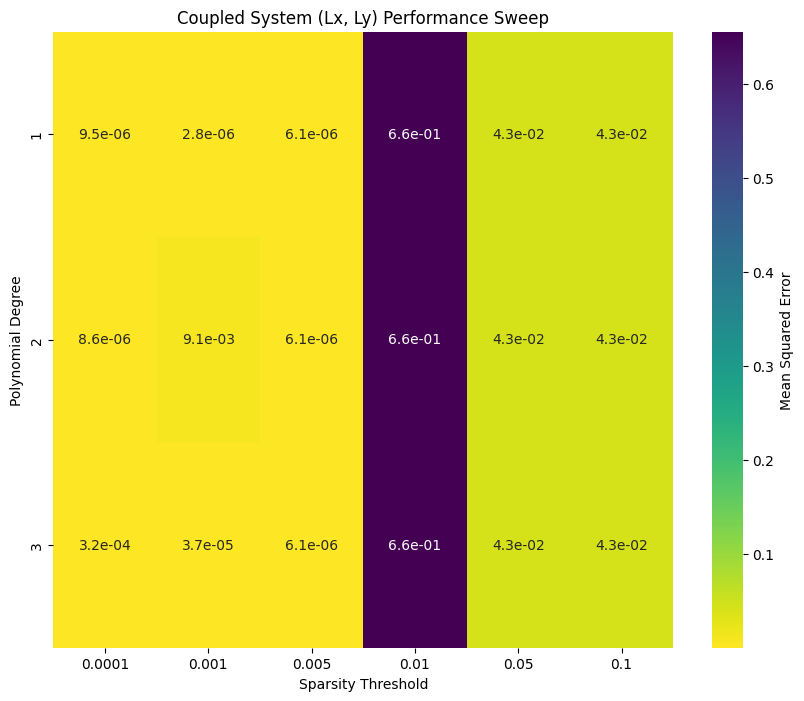


BEST COUPLED MODEL FOUND:
Degree: 1
Threshold: 0.001
Combined MSE: 2.77e-06
Discovered Coupled Equations:
(Lx)' = -0.039 1 + 0.009 Ly + 0.009 Ly + 0.036 1/Lx + -0.041 1/Ly
(Ly)' = -0.020 1 + 0.035 1/Lx + -0.040 1/Ly


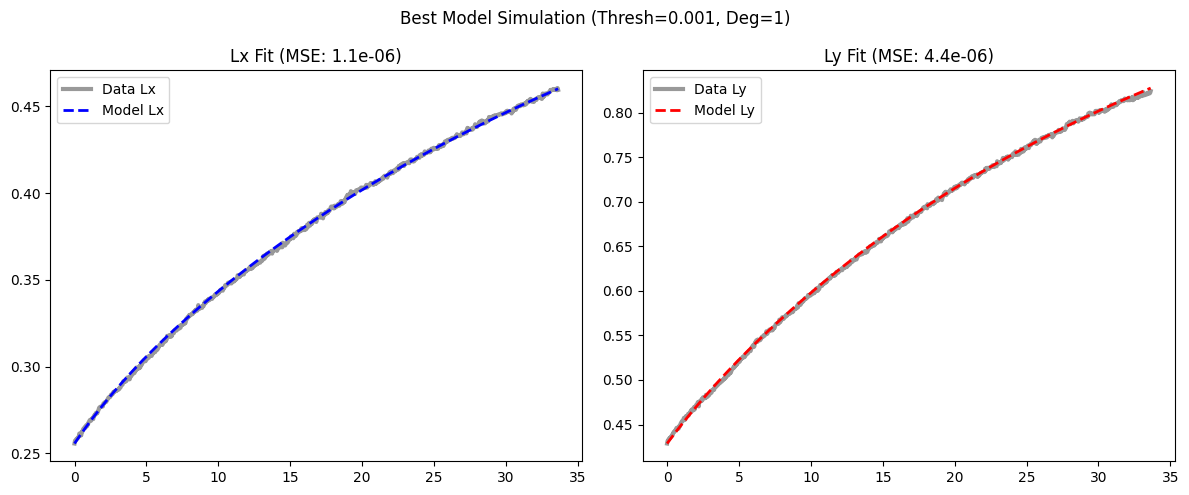

In [10]:
try:
    df_spread = pd.read_csv("dye_spread_lengths.csv")
except FileNotFoundError:
    print("Error: 'dye_spread_lengths.csv' not found. Run the extraction code first.")
    exit()


t = df_spread['Time'].values

X = df_spread[['Lx', 'Ly']].values


start_idx = 0
while np.any(X[start_idx] == 0):
    start_idx += 1

t_fit = t[start_idx:]
X_fit = X[start_idx:]
initial_condition = X_fit[0]

degrees = [1, 2, 3]

thresholds = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

results = []

print(f"Starting sweep over {len(degrees) * len(thresholds)} combinations for Coupled System...")

for deg in degrees:
    for thresh in thresholds:

        library_functions = [lambda x: x, lambda x: 1/(x+1e-6)]
        library_function_names = [lambda x: x, lambda x: "1/" + x]

        custom_lib = ps.CustomLibrary(
            library_functions=library_functions,
            function_names=library_function_names
        )
        poly_lib = ps.PolynomialLibrary(degree=deg)


        combined_lib = poly_lib + custom_lib

        optimizer = ps.STLSQ(threshold=thresh)
        model = ps.SINDy(
            feature_library=combined_lib,
            optimizer=optimizer,
            differentiation_method=ps.FiniteDifference()
        )


        model.fit(X_fit, t=t_fit)


        def model_wrapper(t_val, y_val):
            y_in = y_val.reshape(1, -1)
            return model.predict(y_in)[0]

        try:
            sol = solve_ivp(
                model_wrapper,
                (t_fit[0], t_fit[-1]),
                initial_condition,
                t_eval=t_fit,
                method='RK45',
                max_step=0.1
            )

            if sol.success:
                mse_Lx = np.mean((X_fit[:, 0] - sol.y[0])**2)
                mse_Ly = np.mean((X_fit[:, 1] - sol.y[1])**2)
                total_mse = (mse_Lx + mse_Ly) / 2

                complexity = np.count_nonzero(model.coefficients())
            else:
                total_mse = np.inf
                complexity = 0

        except Exception as e:
            total_mse = np.inf
            complexity = 0

        results.append({
            'Degree': deg,
            'Threshold': thresh,
            'MSE': total_mse,
            'Complexity': complexity
        })

        print(f"Deg: {deg}, Thresh: {thresh} -> MSE: {total_mse:.2e}")

res_df = pd.DataFrame(results)


plot_df = res_df[res_df['MSE'] != np.inf].copy()

if not plot_df.empty:

    pivot_table = plot_df.pivot(index='Degree', columns='Threshold', values='MSE')

    plt.figure(figsize=(10, 8))

    sns.heatmap(pivot_table, annot=True, fmt=".1e", cmap="viridis_r", cbar_kws={'label': 'Mean Squared Error'})
    plt.title("Coupled System (Lx, Ly) Performance Sweep")
    plt.ylabel("Polynomial Degree")
    plt.xlabel("Sparsity Threshold")
    plt.show()

    best_run = plot_df.loc[plot_df['MSE'].idxmin()]

    print("\n" + "="*40)
    print(f"BEST COUPLED MODEL FOUND:")
    print(f"Degree: {int(best_run['Degree'])}")
    print(f"Threshold: {best_run['Threshold']}")
    print(f"Combined MSE: {best_run['MSE']:.2e}")
    print("="*40)

    best_lib = ps.PolynomialLibrary(degree=int(best_run['Degree'])) + \
               ps.CustomLibrary(library_functions=[lambda x: x, lambda x: 1/(x+1e-6)],
                                function_names=[lambda x: x, lambda x: "1/"+x])

    best_opt = ps.STLSQ(threshold=best_run['Threshold'])
    best_model = ps.SINDy(feature_library=best_lib, optimizer=best_opt)
    best_model.fit(X_fit, t=t_fit, feature_names=["Lx", "Ly"])

    print("Discovered Coupled Equations:")
    best_model.print()

    def best_wrapper(t_val, y_val):
        return best_model.predict(y_val.reshape(1, -1))[0]

    sol_best = solve_ivp(best_wrapper, (t_fit[0], t_fit[-1]), initial_condition, t_eval=t_fit, method='RK45')

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(t_fit, X_fit[:, 0], 'k-', alpha=0.4, lw=3, label='Data Lx')
    plt.plot(sol_best.t, sol_best.y[0], 'b--', lw=2, label='Model Lx')
    plt.title(f"Lx Fit (MSE: {np.mean((X_fit[:,0]-sol_best.y[0])**2):.1e})")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(t_fit, X_fit[:, 1], 'k-', alpha=0.4, lw=3, label='Data Ly')
    plt.plot(sol_best.t, sol_best.y[1], 'r--', lw=2, label='Model Ly')
    plt.title(f"Ly Fit (MSE: {np.mean((X_fit[:,1]-sol_best.y[1])**2):.1e})")
    plt.legend()

    plt.suptitle(f"Best Model Simulation (Thresh={best_run['Threshold']}, Deg={int(best_run['Degree'])})")
    plt.tight_layout()
    plt.show()

else:
    print("All combinations failed to produce a stable simulation.")

# **Model trained on 80% of data and tested on 20% of data**

--- Processing Video: /content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4 ---
Data saved to: dye_spread_lengths.csv

PART 2: Splitting Data (80% Train / 20% Test)
Total Valid Frames: 1009
Training Frames: 807 (0.00s to 26.89s)
Testing Frames : 202 (26.93s to 33.63s)

Hyperparameter Sweep on TRAINING DATA ONLY
Testing 3 combinations...

  > Testing Degree 1, Threshold 0.0001... Done. MSE: 3.69e-06
  > Testing Degree 2, Threshold 0.0001... Done. MSE: 4.08e-06
  > Testing Degree 3, Threshold 0.0001... Done. MSE: 5.02e-05

WINNER (Best Coupled Model on Training Data):
Degree: 1, Threshold: 0.0001
Training MSE (Combined): 3.69e-06

Discovered Coupled Equations:
(Lx)' = -0.262 1 + 0.726 Lx + -0.315 Ly + 0.726 Lx + -0.315 Ly + 0.207 1/Lx + -0.272 1/Ly
(Ly)' = -0.302 1 + 0.807 Lx + -0.356 Ly + 0.807 Lx + -0.356 Ly + 0.289 1/Lx + -0.391 1/Ly

PART 4: Forecasting (Test on unseen 20%)
Test MSE (Lx - Width) : 4.51e-04
Test MSE (Ly - Height): 7.36e-05


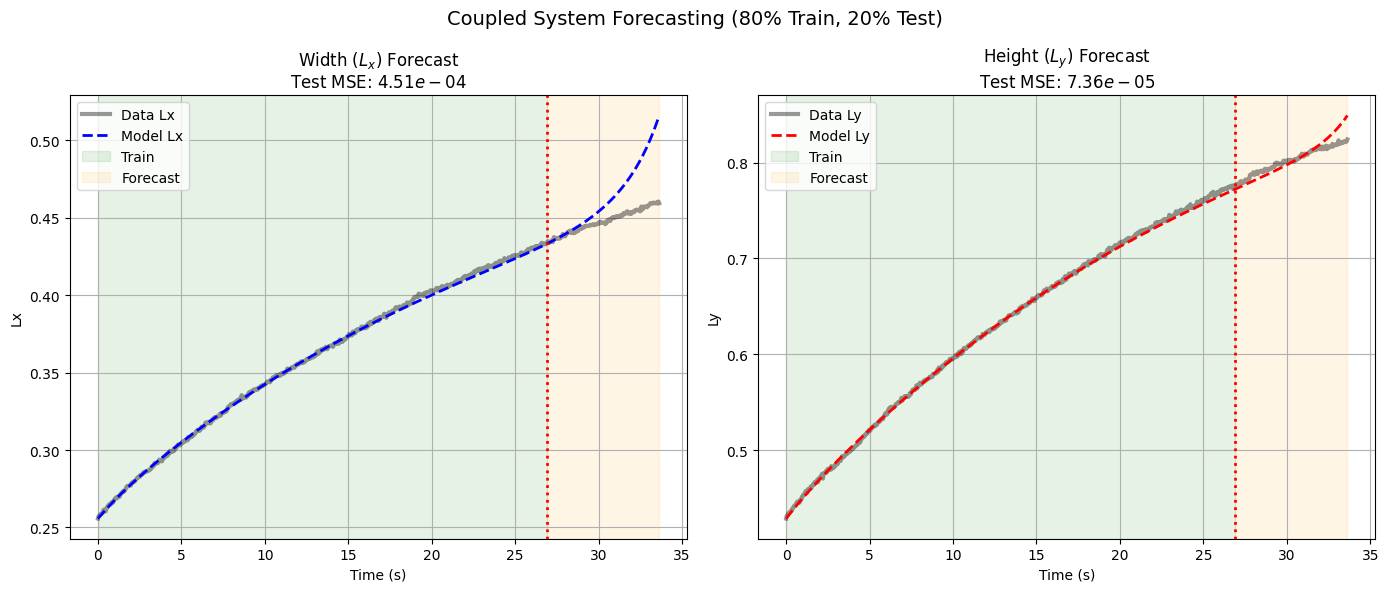

In [11]:
def extract_spread_lengths(video_path, output_csv="dye_spread_lengths.csv"):
    print(f"--- Processing Video: {video_path} ---")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening {video_path}")
        return None, None


    canvas_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    canvas_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    data = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            c = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(c)

            Lx = w / canvas_width
            Ly = h / canvas_height
        else:
            Lx, Ly = 0, 0

        time_sec = frame_idx / fps
        data.append([time_sec, Lx, Ly])
        frame_idx += 1

    cap.release()


    df = pd.DataFrame(data, columns=['Time', 'Lx', 'Ly'])
    df.to_csv(output_csv, index=False)
    print(f"Data saved to: {output_csv}")

    return df

video_filename = "/content/drive/MyDrive/Research with Dr. Acosta Minoli/Video/Video_Difusion_editado_.mp4"
df_spread = extract_spread_lengths(video_filename)

if df_spread is None:
    print("Stopping execution due to video load error.")
    exit()

print("\n" + "="*40)
print("PART 2: Splitting Data (80% Train / 20% Test)")
print("="*40)

t = df_spread['Time'].values
X = df_spread[['Lx', 'Ly']].values

start_idx = 0
while np.any(X[start_idx] == 0):
    start_idx += 1

t_clean = t[start_idx:]
X_clean = X[start_idx:]

split_idx = int(0.80 * len(t_clean))

t_train = t_clean[:split_idx]
X_train = X_clean[:split_idx]

t_test = t_clean[split_idx:]
X_test = X_clean[split_idx:]

print(f"Total Valid Frames: {len(t_clean)}")
print(f"Training Frames: {len(t_train)} (0.00s to {t_train[-1]:.2f}s)")
print(f"Testing Frames : {len(t_test)} ({t_test[0]:.2f}s to {t_test[-1]:.2f}s)")

print("\n" + "="*40)
print("Hyperparameter Sweep on TRAINING DATA ONLY")
print("="*40)

degrees = [1,2,3]
thresholds = [0.0001]
results = []

print(f"Testing {len(degrees)*len(thresholds)} combinations...\n")

for deg in degrees:
    for thresh in thresholds:

        print(f"  > Testing Degree {deg}, Threshold {thresh}...", end=" ")

        library_functions = [lambda x: x, lambda x: 1/(x+1e-6)]
        library_function_names = [lambda x: x, lambda x: "1/" + x]

        custom_lib = ps.CustomLibrary(
            library_functions=library_functions,
            function_names=library_function_names
        )
        poly_lib = ps.PolynomialLibrary(degree=deg)
        combined_lib = poly_lib + custom_lib

        optimizer = ps.STLSQ(threshold=thresh)
        model = ps.SINDy(feature_library=combined_lib, optimizer=optimizer, differentiation_method=ps.FiniteDifference())
        model.fit(X_train, t=t_train)

        def model_wrapper(t_val, y_val):
            return model.predict(y_val.reshape(1, -1))[0]

        try:

            sol = solve_ivp(
                model_wrapper,
                (t_train[0], t_train[-1]),
                X_train[0],
                t_eval=t_train,
                method='RK45',
                max_step=0.1
            )

            if sol.success:

                mse_Lx = np.mean((X_train[:, 0] - sol.y[0])**2)
                mse_Ly = np.mean((X_train[:, 1] - sol.y[1])**2)
                mse_combined = (mse_Lx + mse_Ly) / 2
                complexity = np.count_nonzero(model.coefficients())
                print(f"Done. MSE: {mse_combined:.2e}")
            else:
                mse_combined = np.inf
                complexity = 0
                print("Failed (Integration Error).")

        except Exception as e:
            mse_combined = np.inf
            complexity = 0
            print("Failed (Unstable).")

        results.append({
            'Degree': deg,
            'Threshold': thresh,
            'MSE_Train': mse_combined,
            'Complexity': complexity
        })


res_df = pd.DataFrame(results)
valid_models = res_df[res_df['MSE_Train'] != np.inf].copy()

if not valid_models.empty:
    best_run = valid_models.loc[valid_models['MSE_Train'].idxmin()]

    print(f"\nWINNER (Best Coupled Model on Training Data):")
    print(f"Degree: {int(best_run['Degree'])}, Threshold: {best_run['Threshold']}")
    print(f"Training MSE (Combined): {best_run['MSE_Train']:.2e}")


    best_deg = int(best_run['Degree'])
    best_thresh = best_run['Threshold']

    lib_fns = [lambda x: x, lambda x: 1/(x+1e-6)]
    lib_names = [lambda x: x, lambda x: "1/" + x]

    best_lib = ps.PolynomialLibrary(degree=best_deg) + ps.CustomLibrary(library_functions=lib_fns, function_names=lib_names)
    best_opt = ps.STLSQ(threshold=best_thresh)

    best_model = ps.SINDy(feature_library=best_lib, optimizer=best_opt, differentiation_method=ps.FiniteDifference())
    best_model.fit(X_train, t=t_train, feature_names=["Lx", "Ly"])

    print("\nDiscovered Coupled Equations:")
    best_model.print()


    print("\n" + "="*40)
    print("PART 4: Forecasting (Test on unseen 20%)")
    print("="*40)

    def forecast_wrapper(t_val, y_val):
        return best_model.predict(y_val.reshape(1, -1))[0]

    sol_forecast = solve_ivp(
        forecast_wrapper,
        (t_clean[0], t_clean[-1]),
        X_train[0],
        t_eval=t_clean,
        method='RK45',
        max_step=0.1
    )

    if sol_forecast.success:
        pred_full = sol_forecast.y.T # Shape (N, 2)
        pred_test = pred_full[split_idx:]

        mse_Lx_test = np.mean((X_test[:, 0] - pred_test[:, 0])**2)
        mse_Ly_test = np.mean((X_test[:, 1] - pred_test[:, 1])**2)

        print(f"Test MSE (Lx - Width) : {mse_Lx_test:.2e}")
        print(f"Test MSE (Ly - Height): {mse_Ly_test:.2e}")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        ax1.plot(t_clean, X_clean[:, 0], 'k-', alpha=0.4, lw=3, label='Data Lx')
        ax1.plot(sol_forecast.t, sol_forecast.y[0], 'b--', lw=2, label='Model Lx')
        ax1.axvline(x=t_train[-1], color='r', linestyle=':', linewidth=2)
        ax1.axvspan(t_clean[0], t_train[-1], alpha=0.1, color='green', label='Train')
        ax1.axvspan(t_train[-1], t_clean[-1], alpha=0.1, color='orange', label='Forecast')
        ax1.set_title(rf'Width ($L_x$) Forecast' + '\n' + rf'Test MSE: ${mse_Lx_test:.2e}$')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Lx')
        ax1.legend()
        ax1.grid(True)

        ax2.plot(t_clean, X_clean[:, 1], 'k-', alpha=0.4, lw=3, label='Data Ly')
        ax2.plot(sol_forecast.t, sol_forecast.y[1], 'r--', lw=2, label='Model Ly')
        ax2.axvline(x=t_train[-1], color='r', linestyle=':', linewidth=2)
        ax2.axvspan(t_clean[0], t_train[-1], alpha=0.1, color='green', label='Train')
        ax2.axvspan(t_train[-1], t_clean[-1], alpha=0.1, color='orange', label='Forecast')
        ax2.set_title(rf'Height ($L_y$) Forecast' + '\n' + rf'Test MSE: ${mse_Ly_test:.2e}$')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Ly')
        ax2.legend()
        ax2.grid(True)

        plt.suptitle("Coupled System Forecasting (80% Train, 20% Test)", fontsize=14)
        plt.tight_layout()
        plt.show()

    else:
        print("Forecasting simulation failed.")
else:
    print("No stable models found in training sweep.")